# Extending Variational Boosting to Multiple Competing Variational Families

This jupyter notebook contains all of the code used to generate the plots in the report.

In [1]:
using Plots, LinearAlgebra, ReverseDiff, ForwardDiff, SpecialFunctions, Distributions, Statistics

## ADVI

We begin by implementing the ADVI algorithm that can be used to obtain the first component in the mixture approximation.

In [479]:
function ADVI(logπ, grad, γ, Ngrad, Nobj, ψ0, d, num_iter, transform, diag_sig)
    μs = zeros(d, num_iter)
    Σs = zeros(d, d, num_iter)
    obj = zeros(num_iter)

    for k=1:num_iter
        # transform ψ to mean and covariance
        μ, L = transform(ψ0, diag_sig, d)
        # store parameter
        μs[:,k] = μ
        Σs[:,:,k] = L * transpose(L)
        # sample from κ
        y = rand(MvNormal(d, 1), Ngrad)
        # compute the gradient
        ∇ψ = grad(y, ψ0, logπ, Ngrad, diag_sig, d)
        # take a step
        ψ0 = ψ0 .- γ(k) .* ∇ψ
        # estimate the objective function
        μ, L = transform(ψ0, diag_sig, d)
        if d > 1
            xobj = rand(MvNormal(μ, L * transpose(L)), Nobj)
        else
            xobj = rand(Normal(μ[1], L[1,1]^2), Nobj)
            println(μ[1])
            println(L[1,1]^2)
        end
        for i=1:size(xobj)[1]
            obj[k] += logpdf(MvNormal(μ, L * transpose(L)), xobj[:,i]) - logπ(xobj[:,i])
        end
        obj[k] /= Nobj
    end

    return μs, Σs, obj
end

ADVI (generic function with 1 method)

In [504]:
function transform(ψ, diag_sig, d)
    μ = ψ[1:d]
    if diag_sig
        L = Diagonal(exp.(ψ[d+1:d+d]./2))
    else
        L = reshape(ψ[d+1:end], (d, d))
    end
    return μ, L
end

function logπψ(y, ψ0, logπ, diag_sig, d)
    μ, L = transform(ψ0, diag_sig, d)
    x = vec(μ .+ L * y)
    return -(logπ(x) .+ log(abs(det(L))))
end

function grad(ys, ψ0, logπ, Ngrad, diag_sig, d)
    ret = zeros(size(ψ0)[1])
    for i in 1:Ngrad
        y = vec(ys[:,i])    
        ret = ret .+ ReverseDiff.gradient(ψψ -> logπψ(y, ψψ, logπ, diag_sig, d), ψ0)
    end
    return (ret./Ngrad)
end

grad (generic function with 1 method)

## Variational Boosting

We now implement the variational boosting algorithm.

In [481]:
function sample_from_current_mixture(μs, Σs, λs, Ngrad, d)
    xs = zeros(d, Ngrad)
    num_comp = size(μs)[2]
    for i in 1:Ngrad
        # identify component
        u = rand(Uniform(0,1))
        comp = 0
        for j in 1:num_comp
            if u <= sum(λs[1:j])
                comp = j
                break
            end
        end
        # sample from component
        xs[:,i] = rand(MvNormal(vec(μs[:,comp]), Σs[:,:,comp]))
    end
    return xs
end

function log_mixture(μs, Σs, λs, x)
    mix = 0.
    num_comp = size(μs)[2]
    for i in 1:num_comp
        mix = mix + λs[i] * pdf(MvNormal(vec(μs[:,i]), Σs[:,:,i]), vec(x))
    end
    return log(mix)
end

function compute_EM_weights(μs, Σs, λs, logπ, xs)
    N = size(xs)[2]
    logws = zeros(N)
    for i in 1:N
        x = xs[:,i]
        logws[i] = logπ(x) - log_mixture(μs, Σs, λs, x)
    end
    return exp.(logws)
end

function weighted_EM_initialization(μs, Σs, λs, weights, xs, diag_sig)
    num_comp = size(μs)[2] + 1
    N = size(xs)[2]
    d = size(μs)[1]
    λ = 1. / num_comp
    μ = vec(zeros(d))
    Σ = Diagonal(ones(d))
    # EM loop
    keep = true
    while(keep)
        # E step
        resp = zeros(N, num_comp)
        λs_curr = (1 - λ) .* λs
        for i in 1:N
            x = vec(xs[:,i])
            for j in 1:num_comp
                if j < num_comp
                    resp[i,j] = pdf(MvNormal(vec(μs[:,j]), Σs[:,:,j]), x) * λs_curr[j]
                else
                    resp[i,j] = pdf(MvNormal(vec(μ),Σ), x) * λ
                end
            end
        end
        # normalize by dividing row sum
        rowsum = sum(resp, dims=2)
        resp = resp ./ rowsum
        # M step
        Nk = sum(resp, dims=1)[num_comp]
        newλ = Nk / N
        newμ = vec(zeros(d))
        newΣ = zeros(d,d)
        # update μ
        for i in 1:N
            newμ = newμ .+ (1. / Nk) .* resp[i, num_comp] .* weights[i] .* vec(xs[:,i])
        end
        # update Σ
        for i in 1:N
            diff = vec(xs[:,i]) .- newμ
            newΣ = newΣ .+ (1. / Nk) .* resp[i, num_comp] .* weights[i] .* (diff) * transpose(diff)
        end
        # ensure Σ is Hermitian
        for j in 1:d
            for k in 1:j
                newΣ[j,k] = newΣ[k,j]
            end
        end
        # check convergence
        if (newλ - λ)^2 <= 1e-3
            println("finished initializing ψ and λ")
            keep = false
        end
        # update params
        λ = newλ
        μ = newμ
        Σ = newΣ
    end
    # modify Σ to follow specification of diag_sig
    if diag_sig
        Σ = Diagonal(Σ)
    end

    return λ, μ, Σ
end

In [502]:
function log_mixture(μs, Σs, λs, ψ, λ, x, diag_sig, d)
    mix = 0.
    num_comp = size(μs)[2] + 1
    for i in 1:num_comp
        if i < num_comp
            mix = mix + λs[i] * pdf(MvNormal(vec(μs[:,i]), Σs[:,:,i]), vec(x))
        else
            μ, L = transform(ψ, diag_sig, d)
            mix = mix + λ * pdf(MvNormal(vec(μ), L * transpose(L)), vec(x))
        end
    end
    return log(mix)
end

function obj_comp(y, ψ, λ, logπ, diag_sig, d, μs, Σs, λs)
    num_comp = size(μs)[2] + 1
    ret = 0.    
    for i in 1:num_comp
        if i < num_comp
            if diag_sig
                L = Diagonal(sqrt.(Σs[:,:,i]))
            else
                L = cholesky(Σs[:,:,i]).L
            end
            x = vec(μs[:,i] .+ L * y)
            # ln (mixture approx) - ln (π)
            ret = ret + (1-λ) * λs[i] * (log_mixture(μs, Σs, λs, ψ, λ, x, diag_sig, d) - logπ(x))
        else
            μ, L = transform(ψ, diag_sig, d)
            x = vec(μ .+ L * y)
            # ln (mixture approx) - ln (π)
            ret = ret + λ * (log_mixture(μs, Σs, λs, ψ, λ, x, diag_sig, d) - logπ(x))
        end
    end
    
    return ret
end

function grad_comp(ys, ψ, λ, logπ, Ngrad, diag_sig, d, μs, Σs, λs)
    retψ = zeros(size(ψ)[1])
    retλ = 0.
    for i in 1:Ngrad
        y = vec(ys[:,i])
        retψ = retψ .+ ReverseDiff.gradient(ψψ -> obj_comp(y, ψψ, λ, logπ, diag_sig, d, μs, Σs, λs), ψ)
        retλ = retλ + ForwardDiff.derivative(λλ -> obj_comp(y, ψ, λλ, logπ, diag_sig, d, μs, Σs, λs), λ)
    end
    return (retψ./Ngrad), (retλ/Ngrad)
end

function optimize_component(μs, Σs, λs, λ_k, μ_k, Σ_k, logπ, γ, Ngrad, d, num_iter, transform, diag_sig)
    # turn μ_k and Σ_k to the format of ψ
    ψ = copy(μ_k)
    if diag_sig
        append!(ψ, log.([Σ_k[i,i] for i in 1:d]))
    else
        C = cholesky(Σ_k)
        append!(ψ, C.L)
    end

    # start optimization
    λks = zeros(num_iter)
    μks = zeros(d, num_iter)
    Σks = zeros(d, d, num_iter)
    λ = λ_k

    for k=1:num_iter
        # transform ψ to mean and covariance
        μ, L = transform(ψ, diag_sig, d)
        # store parameter
        μks[:,k] = μ
        Σks[:,:,k] = L * transpose(L)
        λks[k] = λ
        
        # sample from κ
        y = rand(MvNormal(d, 1), Ngrad)
        # compute the gradient
        ∇ψ, ∇λ = grad_comp(y, ψ, λ, logπ, Ngrad, diag_sig, d, μs, Σs, λs)
        # take a step
        ψ = ψ .- γ(k) .* ∇ψ
        λ = λ - (γ(k)/2000) * ∇λ
        # project λ to feasible region
        if λ < 0.
            λ = 0.
        elseif λ > 1.
            λ = 1.
        end
    end

    return λks[num_iter], μks[:,num_iter], Σks[:,:,num_iter]
end

optimize_component (generic function with 1 method)

In [505]:
function VB(logπ, grad, γ, Ncomp, Ngrad, Nobj, ψ0, d, num_iter, transform, diag_sig)
    μs = zeros(d, Ncomp)
    Σs = zeros(d, d, Ncomp)
    λs = [1.]
    objs = zeros(Ncomp)

    # fitting first component
    println("optimizing component 1 / ", Ncomp)
    mus, sigmas, obj = ADVI(logπ, grad, γ, Ngrad, Nobj, ψ0, d, num_iter, transform, diag_sig)
    μs[:,1] = mus[:,num_iter]
    Σs[:,:,1] = sigmas[:,:,num_iter]

    # fitting remaining components
    for k in 2:Ncomp
        println("optimizing component ", k, " / ", Ncomp)
        # init new component
#         xs = sample_from_current_mixture(μs[:,1:k-1], Σs[:,:,1:k-1], λs[1:k-1], 50, d)
#         weights = compute_EM_weights(μs[:,1:k-1], Σs[:,:,1:k-1], λs[1:k-1], logπ, xs)
#         λ_k, μ_k, Σ_k = weighted_EM_initialization(μs[:,1:k-1], Σs[:,:,1:k-1], λs[1:k-1], weights, xs, diag_sig)
        λ_k = 1. / 2.
        μ_k = (-1)^(k-1) .* ones(d)
        Σ_k = Diagonal(ones(d))

        # optimize new component
        λ_k, μ_k, Σ_k = optimize_component(μs[:,1:k-1], Σs[:,:,1:k-1], λs[1:k-1], λ_k, μ_k, Σ_k,
                                           logπ, γ, Ngrad, d, num_iter, transform, diag_sig)
        # update parameters
        λs = (1. - λ_k) .* λs
        push!(λs, λ_k)
        μs[:,k] .= μ_k
        Σs[:,:,k] .= Σ_k
    end

    return μs, Σs, λs
end

VB (generic function with 1 method)

In [506]:
μ = vec([1. 1.])
Σ = [7. 2.; 2. 1.]
println(Σ)
logπ = x -> logpdf(MvNormal(μ, Σ), x)
γ = k -> 1. /sqrt(k)
Ngrad = 400
Nobj = 400
ψ0 = vec([5. 5. 3. 3. 4. 4.])
diag_sig = false
d = 2
num_iter = 100
Ncomp = 2

μs, Σs, λs = VB(logπ, grad, γ, Ncomp, Ngrad, Nobj, ψ0, d, num_iter, transform, diag_sig);

# for i in 1:Ncomp
#     println("mu: ", μs[:,i])
#     println("sigma: ", Σs[:,:,i])
#     println("lambda: ", λs[i])
# end

[7.0 2.0; 2.0 1.0]
optimizing component 1 / 2
optimizing component 2 / 2
ReverseDiff.TrackedReal{Float64,Float64,ReverseDiff.TrackedArray{Float64,Float64,2,Array{Float64,2},Array{Float64,2}}}[TrackedReal<8ls>(1.0, 0.0, 28u, 1, GMh) TrackedReal<GmV>(0.0, 0.0, 28u, 3, GMh); TrackedReal<1bc>(0.0, 0.0, 28u, 2, GMh) TrackedReal<CwC>(1.0, 0.0, 28u, 4, GMh)]
ReverseDiff.TrackedReal{Float64,Float64,ReverseDiff.TrackedArray{Float64,Float64,2,Array{Float64,2},Array{Float64,2}}}[TrackedReal<CBp>(1.0, 0.0, 28u, 1, 4Ba) TrackedReal<5Mo>(0.0, 0.0, 28u, 3, 4Ba); TrackedReal<LoP>(0.0, 0.0, 28u, 2, 4Ba) TrackedReal<KTm>(1.0, 0.0, 28u, 4, 4Ba)]


MethodError: [91mMethodError: no method matching PDMats.PDMat(::ReverseDiff.TrackedArray{Float64,Float64,2,Array{Float64,2},Array{Float64,2}})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  PDMats.PDMat(::AbstractArray{T,2} where T, [91m::Cholesky[39m) at C:\Users\chenn\.julia\packages\PDMats\HCniD\src\pdmat.jl:13[39m
[91m[0m  PDMats.PDMat([91m::Array{T,2} where T[39m) at C:\Users\chenn\.julia\packages\PDMats\HCniD\src\pdmat.jl:19[39m
[91m[0m  PDMats.PDMat([91m::Symmetric[39m) at C:\Users\chenn\.julia\packages\PDMats\HCniD\src\pdmat.jl:20[39m
[91m[0m  ...[39m

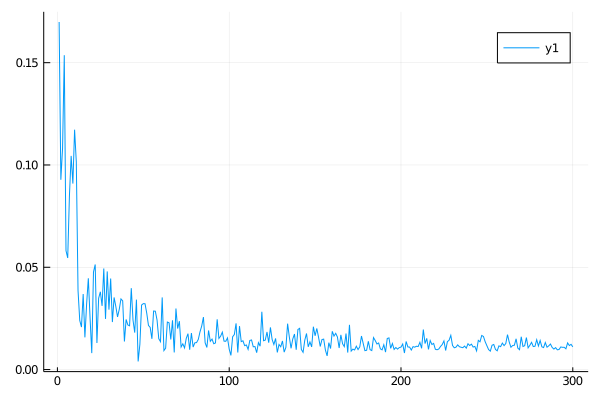

In [408]:
# plot([1:1:num_iter;], obj)

In [402]:
for i in 1:Ncomp
    println("mu: ", μs[:,i])
    println("sigma: ", Σs[:,:,i])
    println("lambda: ", λs[i])
end

mu: [3.0, 3.0]
sigma: [1.0 0.0; 0.0 1.0]
lambda: 0.1042076793979238
mu: [-0.05119552107021508, -0.05796497230336486]
sigma: [0.9177845103801933 0.0; 0.0 0.9179265627716129]
lambda: 0.36642462520678093
mu: [-0.004815002317356398, -0.002359790888900178]
sigma: [0.9886551943992434 0.0; 0.0 0.9734991030296853]
lambda: 0.5293676953952953
